# RTM imaging condition interval
*by [Alan Richardson](mailto:alan@ausargeo.com) ([Ausar Geophysical](http://www.ausargeo.com))*

To generate an image of the subsurface, Reverse Time Migration applies what is referred to as an  "imaging condition" to the forward propagated source wavefield, and the backward propagated data wavefield. This is also used in FWI to calculate the gradient. For numerical stability, the time step length in the finite difference calculations used to propagate the wavefields tends to be very small. It may be so small that one can get away with only applying the imaging condition every few time steps without significantly affecting the resulting image - saving unneccessary computation. In this notebook, I investigate the effect of reducing the frequency of imaging condition applications.

It seems likely that higher frequency waves need to be imaged more frequently. The number of times we sample the wave with the imaging condition per wave period, which I suspect should be inversely proportional to the error caused by discretization of the imaging condition integral, is 1 / (*k* x *freq* x *delta_t*), where *freq* is the wave frequency, *delta_t* is the time step size of our wave propagator, and *k* is the interval (the number of time steps) between imaging condition applications. With the peak frequency of the source as *freq*, we could use this equation to maintain a similar level of error across all images.

I will use a simple 1D RTM implementation from one of my [other repositories](https://github.com/ar4/rtm_1d).

In [41]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

In [42]:
from rtm_1d import rtm

## Experiment
To test how the image error varies with imaging condition application frequency and source wavelet peak frequency, I will run 1D RTM on random models as these values vary and then measure how the resulting images change. All of the models have the same mean wave speed (2500 m/s), but the wave speed should not affect the results.

To reduce the risk that the results are affected by the velocity model used, I run the test with 10 different models and average the results.

I use 5 different frequencies between 15 and 25 Hz, and 15 different imaging condition application intervals from 1 to 400 time steps (where the time step size is 0.0001 s).

I generate synthetic data for all of the models and all of the peak frequencies considered, and then migrate the data using RTM with a migration model that is a constant 2500 m/s. I measure the image error by calculating the RMS difference with the image produced by applying the imaging condition at every time step, and normalizing by the range of the latter.

In [43]:
num_models = 10
model_len = 200
const_len = 40
delta_x = 5
delta_t = 0.0001
base_vel = 2500
vel_range = 2000
num_freqs = 5
min_freq = 15
max_freq = 25
freqs = np.linspace(min_freq, max_freq, num_freqs)
mute_len = int(2 * const_len * delta_x / base_vel / delta_t)
num_steps = int(2 * model_len * delta_x / base_vel / delta_t)
mig_models = base_vel * np.ones([num_models, model_len], np.float32)
exact_models = np.copy(mig_models)
exact_models[:, const_len:] += (vel_range * np.random.rand(num_models, model_len - const_len)
                                - vel_range/2)

In [44]:
rtmobj = rtm.Rtm(delta_x, delta_t)

In [45]:
def ricker(freq, length, delta_t, peak_time):
    """Return a Ricker wavelet with the specified central frequency."""
    time = np.arange(-peak_time, length * delta_t - peak_time, delta_t,
                     dtype=np.float32)
    time = time[:length]
    waveform = ((1.0 - 2.0 * np.pi**2 * freq**2 * time**2)
                * np.exp(-np.pi**2 * freq**2 * time**2))
    return waveform

In [46]:
data = np.zeros([num_freqs, num_models, 1, num_steps], np.float32)
sources = np.zeros([num_freqs, num_steps], np.float32)
source_x = 1
receivers_x = [1]
for freq_idx, freq in enumerate(freqs):
    sources[freq_idx, :] = ricker(freq, num_steps, delta_t, 0.1)
    for model_idx in range(num_models):
        data[freq_idx, model_idx, 0, :] = rtmobj.model_shot(exact_models[model_idx, :],
                                                            sources[freq_idx, :], source_x,
                                                            receivers_x, num_steps * delta_t)
data[:, :, 0, :mute_len] = 0

In [47]:
max_interval = 400
num_intervals = 15
intervals = np.linspace(1, max_interval, num_intervals, dtype=np.int)
images = np.zeros([num_intervals, num_freqs, num_models, model_len], np.float32)

In [48]:
for interval_idx, interval in enumerate(intervals):
    for freq_idx in range(num_freqs):
        for model_idx in range(num_models):
            images[interval_idx, freq_idx, model_idx, :] = \
            rtmobj.migrate_shot(mig_models[model_idx,:], sources[freq_idx, :], source_x,
                                data[freq_idx, model_idx, :, :], receivers_x, interval)

In [50]:
nrmse = np.zeros([num_freqs, num_intervals-1])
for freq_idx in range(num_freqs):
    nrmse[freq_idx, :] = (np.sqrt(np.mean((images[1:, freq_idx, :, :]
                                         - images[0, freq_idx, :, :])**2,
                                        axis=(1, 2)))
                         / (np.max(images[0, freq_idx, :, :])
                            - np.min(images[0, freq_idx, :, :])) * 100)

## Results
The normalized RMS errors are plotted below.

As expected, the error rises as the interval gets larger. Also as expected, the error is generally larger for higher frequency waves.

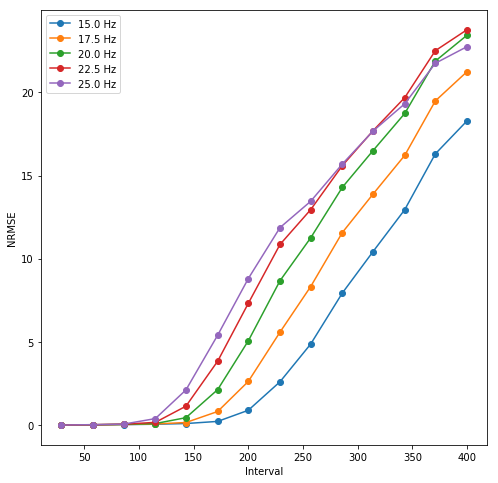

In [51]:
plt.figure(figsize=(8,8))
for freq_idx in range(num_freqs):
    plt.plot(intervals[1:], nrmse[freq_idx], 'o-', label=('%.1f Hz' % freqs[freq_idx]))
plt.ylabel('NRMSE')
plt.xlabel('Interval')
plt.legend()

(160, 260)

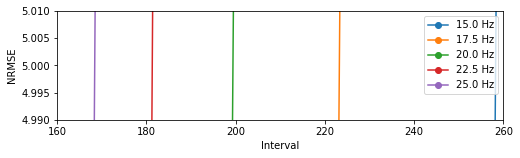

In [58]:
plt.figure(figsize=(8,2))
for freq_idx in range(num_freqs):
    plt.plot(intervals[1:], nrmse[freq_idx], 'o-', label=('%.1f Hz' % freqs[freq_idx]))
plt.ylabel('NRMSE')
plt.xlabel('Interval')
plt.legend()
plt.ylim([4.99,5.01])
plt.xlim([160,260])

If we want to maintain the error at the 5% level on the plot, we need to apply the imaging condition about every 170 time steps for the 25 Hz wave, 180 for 22.5 Hz, 200 for 20 Hz, 225 for 17.5 Hz, and 260 for 15 Hz. Inserting these into the equation in the introduction, we can calculate how many times the waves are sampled per wave period by the imaging condition.

In [59]:
req_int = [260, 225, 200, 180, 170]
num_samples_per_wavelength = [1 / (req_int[i] * freqs[i] * 0.0001) for i in range(5)]
print(num_samples_per_wavelength)

[2.5641025641025639, 2.5396825396825395, 2.5, 2.4691358024691357, 2.3529411764705879]


As expected, the number is very similar across the frequencies. To maintain that error level, we need to sample the wave for the imaging condition about 2.5 times per wave period, regardless of the wave frequency.

Let's now look at how the image changes with increasing imaging condition interval. I only plot the images for one model and one frequency (25 Hz). The 1D images are along the x axis, and are stacked on the y axis with varying imaging condition interval. As there are fewer image contributions from the real reflectors when the interval gets larger, noise will tend to get relatively amplified. This becomes apparent in the result below beyond an imaging condition interval of about 200 time steps.

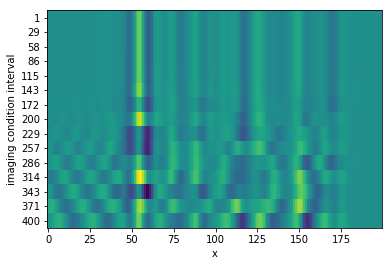

In [64]:
plt.imshow(images[:, -1, 0, :], aspect='auto')
plt.xlabel('x')
plt.ylabel('imaging condition interval')
plt.yticks(np.arange(15), intervals);

## Conclusion
The hypothesis that we can control the discretisation error in the imaging condition integral by choosing the number of times the imaging condition is applied per wave period appears to be correct. In this test, applying it about 2.5 times per period seems like a reasonable minimum.

It is possible that fancier integration methods (such as Simpson or Romberg) might improve the results, but it is probably only worthwhile to consider those if you are using an imaging condition that is especially computationally expensive to apply.